<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Customise/SubclassCustom/Tracking_metrics_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking metrics in custom training loops
In this reading you will learn how to track metrics such as accuracy within custom training loops.

Tracking performance metrics is useful to check the performance of your model during and after training. Previously, we have passed in a list of metrics to the `model.fit` or `model.evaluate` methods when using the higher level APIs. However, we would still like to be able to evaluate our model on performance metrics in a custom training loop.

## Load the dataset
For this reading notebook we will use the Reuters dataset. The cells below load and process the dataset, and prepare it as `tf.data.Dataset` objects.

In [1]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
from sklearn import model_selection

# Load the dataset
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.reuters.load_data(num_words=10000, skip_top=50)

# Define the class names
class_names = [
    'cocoa', 'grain', 'veg-oil', 'earn', 'acq', 'wheat', 'copper', 'housing',
    'money-supply', 'coffee', 'sugar', 'trade', 'reserves', 'ship', 'cotton',
    'carcass', 'crude', 'nat-gas', 'cpi', 'money-fx', 'interest', 'gnp',
    'meal-feed', 'alum', 'oilseed', 'gold', 'tin', 'strategic-metal',
    'livestock', 'retail', 'ipi', 'iron-steel', 'rubber', 'heat', 'jobs',
    'lei', 'bop', 'zinc', 'orange', 'pet-chem', 'dlr', 'gas', 'silver',
    'wpi', 'hog', 'lead'
]

# Pad and truncate the train and test inputs
padded_train_data = tf.keras.utils.pad_sequences(
    sequences=train_data, maxlen=100, truncating='post')
padded_test_data = tf.keras.utils.pad_sequences(
    sequences=test_data, maxlen=100, truncating='post')

# Split the training data into training and validation sets
train_data, valid_data, train_labels, valid_labels = \
    model_selection.train_test_split(
        padded_train_data, train_labels, test_size=0.3)

# Create Datasets for training, validation and test data
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=train_labels.shape[0])
train_dataset = train_dataset.batch(batch_size=32)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(valid_data, valid_labels))
valid_dataset = valid_dataset.shuffle(buffer_size=valid_labels.shape[0])
valid_dataset = valid_dataset.batch(batch_size=32)

test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(padded_test_data, test_labels))
test_dataset = test_dataset.batch(batch_size=32)

2110848/2110848 [==============================] - 0s 0us/step


## Define the model, optimizer and loss function

Before getting to the custom training loop, we first define the model. We will use the model subclassing API to build a recurrent neural network for this example.

In [5]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Build the model
class RNNModel(tf.keras.Model):
    def __init__(self, units_1, units_2, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.embedding = tf.keras.layers.Embedding(
            input_dim=10000, output_dim=16, input_length=100)
        self.gru_1 = tf.keras.layers.Bidirectional(
                tf.keras.layers.GRU(units=units_1, return_sequences=True),
            merge_mode="sum")
        self.gru_2 = tf.keras.layers.GRU(units=units_2)
        self.dense = tf.keras.layers.Dense(units=num_classes,
            activation=tf.keras.activations.softmax)

    def call(self, inputs):
        h = self.embedding(inputs)
        h = self.gru_1(h)
        h = self.gru_2(h)
        return self.dense(h)

# Instantiate the model
model = RNNModel(units_1=32, units_2=16, num_classes=46, name='rnn_model')

## Build the custom training loop

The following function computes the model predictions, loss and gradients, for use in the custom training loop.

In [6]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")

# Define a function to compute the loss and gradients
@tf.function
def get_preds_loss_grads(model, inputs, targets, loss_object):
    with tf.GradientTape() as tape:
        preds = model(inputs=inputs)
        loss = loss_object(y_true=targets, y_pred=preds)
        grads = tape.gradient(target=loss,
            sources=model.trainable_variables)
    return preds, loss, grads

Metric objects can be created and used to track performance measures in the custom training loop. We will set up our custom training loop to track the average loss, and area under the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC AUC). Of course there are many more metrics that you could use.

In the following custom training loop, we define an outer loop for the epochs, and an inner loop for the batches in the training dataset. At the end of each epoch we run a validation loop for a number of iterations.

Inside the inner loop we use the metric objects to calculate the metric evaluation values. These values are then appended to the empty lists. The metric objects are re-initialised at the start of each epoch.

The following training loop may take a while to run. Feel free to reduce the number of epochs if you want.

Epoch 000: Training loss: 2.703, ROC AUC: 85.506%
           Validation loss: 2.690, ROC AUC 85.617%
Epoch 001: Training loss: 2.559, ROC AUC: 87.159%
           Validation loss: 2.557, ROC AUC 87.178%
Epoch 002: Training loss: 2.508, ROC AUC: 87.756%
           Validation loss: 2.507, ROC AUC 87.771%
Epoch 003: Training loss: 2.481, ROC AUC: 88.101%
           Validation loss: 2.480, ROC AUC 88.114%
Epoch 004: Training loss: 2.463, ROC AUC: 88.339%
           Validation loss: 2.462, ROC AUC 88.357%


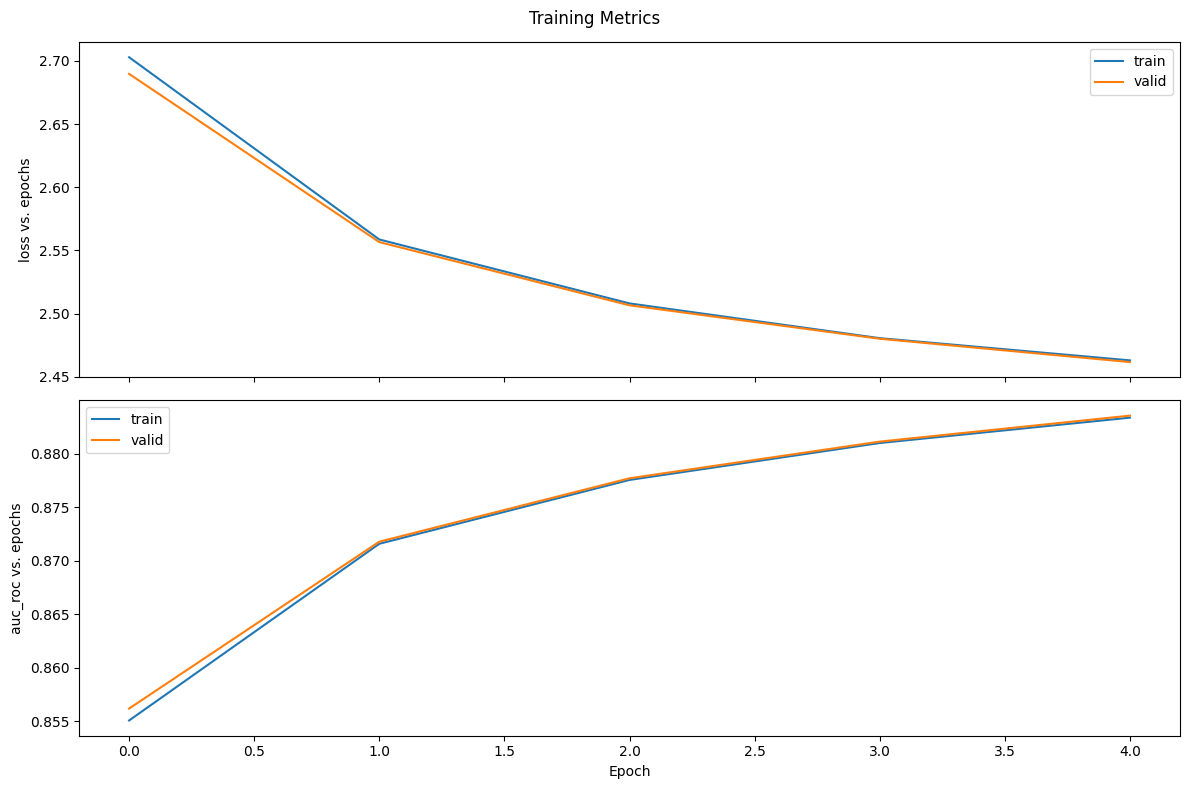

In [7]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel("ERROR")
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Run the custom training loop
# Create lists to accumulate the metric values
avg_metric = tf.keras.metrics.Mean()
auc_roc_metric = tf.keras.metrics.AUC(curve="ROC")
train_loss_results, train_auc_roc_results = [], []
valid_loss_results, valid_auc_roc_results = [], []

# The loss function for our model should be the sparse categorical
# cross entropy, since the labels are in sparse form:
# Define the loss
loss_crossentropy = tf.keras.losses.SparseCategoricalCrossentropy()

# We will use the SGD optimizer with Nesterov momentum,
# and a learning rate of 0.005:
# Define the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005,
    momentum=0.9, nesterov=True)

num_epochs = 5
valid_steps = 10
for epoch in range(num_epochs):
    for inputs, labels in train_dataset:
        preds, loss, grads = get_preds_loss_grads(model=model,
            inputs=inputs, targets=labels, loss_object=loss_crossentropy)
        optimizer.apply_gradients(grads_and_vars=\
            zip(grads, model.trainable_variables))
        avg_metric(values=loss)
        auc_roc_metric(y_true=tf.keras.utils.to_categorical(
                y=labels, num_classes=46),
            y_pred=preds)
    train_loss_results.append(avg_metric.result().numpy())
    train_auc_roc_results.append(auc_roc_metric.result().numpy())
    print("Epoch {:03d}: Training loss: {:.3f}, ROC AUC: {:.3%}"\
        .format(epoch, avg_metric.result(), auc_roc_metric.result()))

    for inputs, labels in valid_dataset.take(count=valid_steps):
        preds = model(inputs=inputs)
        avg_metric(values=loss_crossentropy(y_true=labels, y_pred=preds))
        auc_roc_metric(y_true=tf.keras.utils.to_categorical(
                y=labels, num_classes=46),
            y_pred=preds)
    valid_loss_results.append(avg_metric.result().numpy())
    valid_auc_roc_results.append(auc_roc_metric.result().numpy())
    print("           Validation loss: {:.3f}, ROC AUC {:.3%}"\
        .format(avg_metric.result(), auc_roc_metric.result()))

# Plot the learning curves
df_history = pd.DataFrame({
    "epoch": np.arange(num_epochs),
    "train_loss": np.array(train_loss_results),
    "valid_loss": np.array(valid_loss_results),
    "train_auc_roc": np.array(train_auc_roc_results),
    "valid_auc_roc": np.array(valid_auc_roc_results)
})

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 8))
fig.suptitle(t="Training Metrics")
axes[1].set_xlabel(xlabel="Epoch")
for ax, metric in zip(axes, ["loss", "auc_roc"]):
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{metric}")
    sns.lineplot(ax=ax, label="valid", data=df_history,
        x="epoch", y=f"valid_{metric}")
    ax.legend(loc="best")
    ax.set_ylabel(ylabel=f"{metric} vs. epochs")
    ax.set_title
fig.tight_layout()
plt.show()

## Test the model
Similarly, we can calculate the loss and metric values on the test dataset.

In [ ]:
# Create metric objects for testing
avg_metric = tf.keras.metrics.Mean()
auc_roc_metric = tf.keras.metrics.AUC(curve="ROC")

# Calculate metrics on the test set
for inputs, labels in test_dataset:
    model_pred = model(inputs)
    test_epoch_loss_avg(loss(labels, model_pred))
    test_epoch_roc_auc(to_categorical(labels, num_classes=46), model_pred)

print("Test loss: {:.3f}".format(
    test_epoch_loss_avg.result().numpy()))
print("Test ROC AUC: {:.3%}".format(
    test_epoch_roc_auc.result().numpy()))

Test loss: 2.380
Test ROC AUC: 88.949%


## Further reading and resources
* https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough#training_loop
* https://www.tensorflow.org/api_docs/python/tf/keras/metrics
* https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve